# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
# from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('Data/bank_fin.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная 
- deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [5]:
# исследуем данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [6]:
df.isnull().sum().sort_values(ascending=False)[:5]

balance     25
age          0
day          0
poutcome     0
previous     0
dtype: int64

### Задание 2

In [7]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [8]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].str.replace('$', '').astype(float)
df.balance.mean().round(3)

1529.129

### Задание 4

In [9]:
# обработаем пропуски в признаки balance , заменив их на медианные значения по данному признаку

# df['balance'][df['balance'].isnull()] = df.balance.median()
df['balance'].fillna(df.balance.median(), inplace=True)
df.balance.mean().round(3)

1526.936

### Задание 5

In [10]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'][df['job'] == 'unknown'] = df['job'].mode()[0]
df['education'][df['education'] == 'unknown'] = df.education.mode()[0]

# средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
mask1 = df['education'] == df['education'].mode()[0]
mask2 = df['job'] == df['job'].mode()[0]
df['balance'][mask1 & mask2].mean().round(3)

1598.883

In [11]:
df.job.value_counts()

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

### Задание 6

In [12]:
# удалим все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    print(f'Нижняя граница: {lower_bound.round()} \nВерхняя граница: {upper_bound.round()} \n')
    return outliers, cleaned

outliers, df_cleaned = outliers_iqr(df, 'balance')
print(f'Число объектов осталось после удаления всех выбросов: {df_cleaned.shape[0]}')

Нижняя граница: -2241.0 
Верхняя граница: 4063.0 

Число объектов осталось после удаления всех выбросов: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [13]:
df_cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Количество клиентов, открывших депозит: 4681
Количество клиентов, неоткрывших депозит: 5424


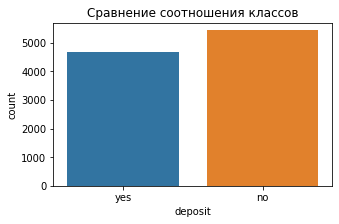

In [14]:
# изучим соотношение классов в данных на предмет несбалансированности, проиллюстрируем результат
df_cleaned.head()

fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(x='deposit', data=df_cleaned) 
ax.set_title('Сравнение соотношения классов');

class_percent = df_cleaned['deposit'].value_counts()
print(f"Количество клиентов, открывших депозит: {class_percent['yes']}")
print(f"Количество клиентов, неоткрывших депозит: {class_percent['no']}")


,deposit,count
0,no,5424
1,yes,4681


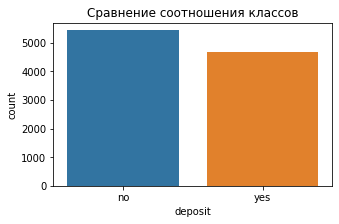

In [15]:
# Возможный вариант проверки соотношения классов через группировку
grouped_data = df_cleaned.groupby(by='deposit', as_index=False)['age'].count()
grouped_data.rename(columns={'age': 'count'}, inplace=True)
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=grouped_data, x='deposit', y='count')
ax.set_title('Сравнение соотношения классов');
grouped_data.head()

Начнём с описательных статистик для количественных переменных.

Рассчитайте их и продумайте подробную интерпретацию.
Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
Рассмотрите минимальные и максимальные значения.
Посмотрите на меры разброса и оцените, насколько данные вариативны.
Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.
Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

### Задания 2 и 3

In [16]:
#рассчитаем описательные статистики для количественных переменных, проинтерпретируем результат
df_cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [17]:
df_cleaned.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.115164,0.000396,-0.006007,-0.001143,0.006107,0.025383
balance,0.115164,1.000000,-0.009987,0.025781,-0.042689,0.045155,0.060419
day,0.000396,-0.009987,1.000000,-0.016695,0.142169,-0.078757,-0.059739
duration,-0.006007,0.025781,-0.016695,1.000000,-0.042576,-0.033053,-0.034233
campaign,-0.001143,-0.042689,0.142169,-0.042576,1.000000,-0.105214,-0.052312
pdays,0.006107,0.045155,-0.078757,-0.033053,-0.105214,1.000000,0.513708
previous,0.025383,0.060419,-0.059739,-0.034233,-0.052312,0.513708,1.000000


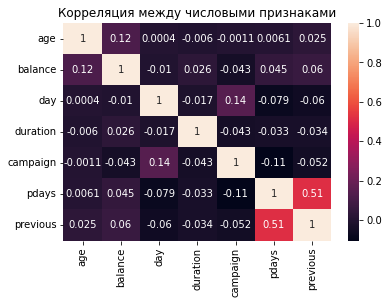

In [18]:
sns.heatmap(df_cleaned.corr(), annot=True)
plt.title('Корреляция между числовыми признаками');

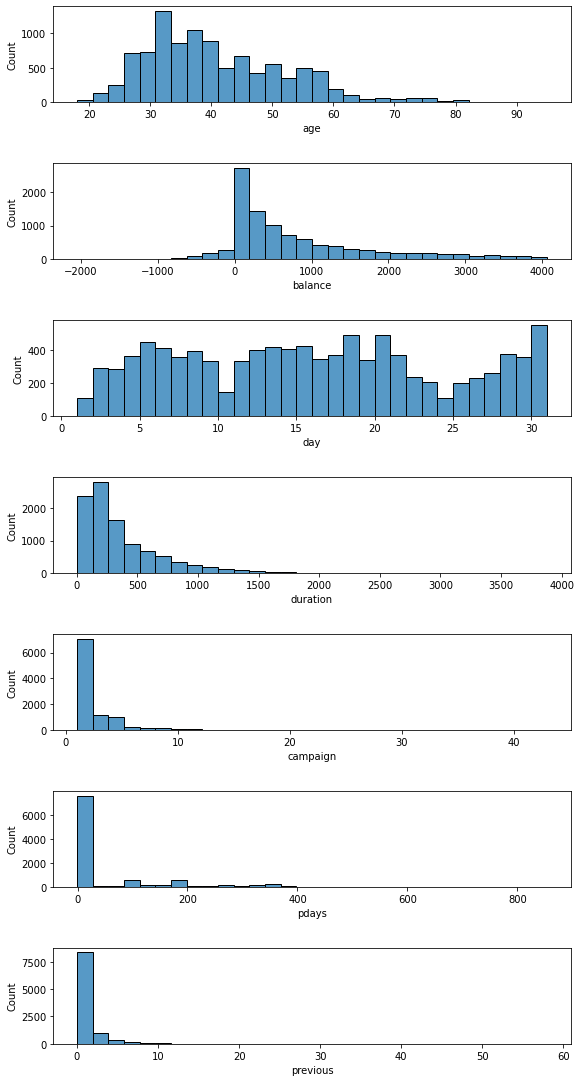

In [19]:
# Создаем списки чистовых и категариальных признаков
num_cols = list(df_cleaned.select_dtypes(include=['float64', 'int64']).columns)
cat_cols = list(df_cleaned.select_dtypes(include=['object']).columns)
# print(num_cols)
# print()
# print(cat_cols)

fig, axes = plt.subplots(nrows=len(num_cols), figsize=(8,15))
fig.tight_layout(h_pad = 4) # настраиваем промежутки между графиками
for i, col in enumerate(num_cols):
    sns.histplot(data=df_cleaned,
                 x=col,
                 ax=axes[i],
                 bins=30)
plt.show()

In [20]:
df_cleaned['campaign'].sort_values(ascending=False).head(10)

6927     43
7240     43
7139     41
9683     33
4912     32
7237     32
10293    31
10960    30
10865    30
7763     30
Name: campaign, dtype: int64

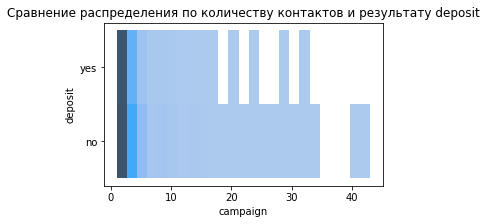

In [21]:
# Сравнение распределения по количеству контактов и результату deposit
fig = plt.figure(figsize=(5, 3))
sns.histplot(
    data=df_cleaned,
    x='campaign',
    y='deposit',
    bins=25
)
plt.title('Сравнение распределения по количеству контактов и результату deposit')
plt.show()

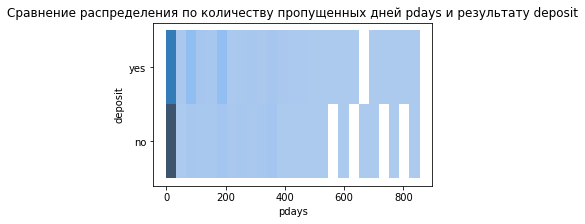

In [22]:
# Сравнение распределения по количеству пропущенных дней pdays и результату deposit
fig = plt.figure(figsize=(5, 3))
sns.histplot(
    data=df_cleaned,
    x='pdays',
    y='deposit',
    bins=25
)
plt.title('Сравнение распределения по количеству пропущенных дней pdays и результату deposit')
plt.show()

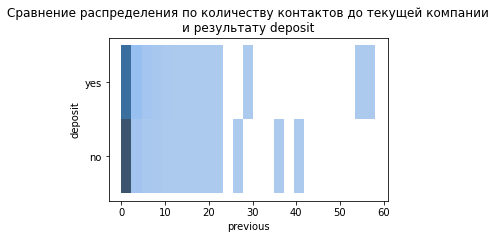

In [23]:
# Сравнение распределения по количеству контактов до текущей компании и результату deposit
fig = plt.figure(figsize=(5, 3))
sns.histplot(
    data=df_cleaned,
    x='previous',
    y='deposit',
    bins=25
)
plt.title('Сравнение распределения по количеству контактов до текущей компании\nи результату deposit')
plt.show()

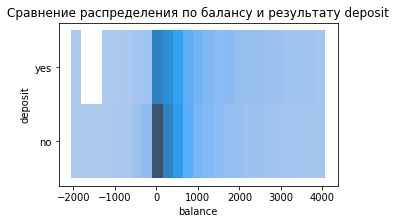

In [24]:
# Сравнение распределения по балансу и результату deposit
fig = plt.figure(figsize=(5, 3))
sns.histplot(
    data=df_cleaned,
    x='balance',
    y='deposit',
    bins=25
)
plt.title('Сравнение распределения по балансу и результату deposit')
plt.show()

In [25]:
# Сравнение распределения по балансу и результату deposit
px.histogram(
    data_frame=df_cleaned,
    x='balance',
    color='deposit',
    nbins=50,
    title=('Сравнение распределения по балансу и результату deposit')
)

In [26]:
# проверка на выбросы - редкие значения
# df_cleaned['previous'].sort_values(ascending=False).head(20)
df_cleaned['previous'].value_counts(ascending=True).head(10)

37    1
58    1
18    1
22    1
30    1
29    1
55    1
41    1
20    2
27    2
Name: previous, dtype: int64

#### Выводы по графикам:
- age - распределение данных близко к нормальному или логнормальному, минимальное и максимальное значение являются легитимными и скорее всего не являются выбросами
- balance - распределение данных близко к логнормальному, очевидных выбросов в данных незаметно
- day - признак распределен почти равнометно, наибольшее количество контактов заметно в конце месяца
- duration - распределение данных близко к логнормальному, очевидных выбросов в данных незаметно
- campaign - распределение данных близко к логнормальному, очевидных выбросов в данных незаметно, на дополнительном графике не выявлено взаимосвязи между количеством контактов и положительным результатом deposit
- pdays - распределение данных близко к логнормальному, очевидных выбросов в данных незаметно, большинство данных сосредоточено у нуля, также не выявлено взаимосвязи с положительным результатом deposit
- previous - распределение данных близко к логнормальному, очевидных выбросов в данных незаметно, большинство данных сосредоточено у нуля, на дополнительном графике не выявлено взаимосвязи с положительным результатом deposit


### Задания 4 и 5

In [27]:
#рассчитаем описательные статистики для категориальных переменных, проинтерпретируем результат
df_cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


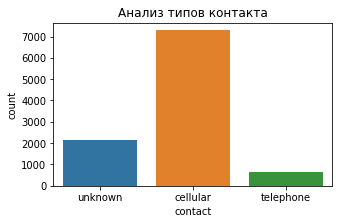

In [28]:
fig = plt.figure(figsize=(5,3))
sns.countplot(data=df_cleaned, x='contact')
plt.title('Анализ типов контакта');

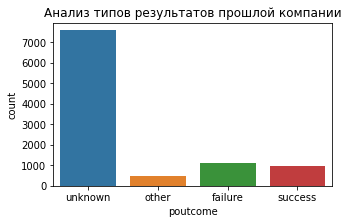

In [29]:
fig = plt.figure(figsize=(5,3))
sns.countplot(data=df_cleaned, x='poutcome')
plt.title('Анализ типов результатов прошлой компании');

Выводы: 
- маркетинговая компания проходила 12 месяцев, больше всего контактов в мае
- самый частый тип занятости - management, всего 11 типов
- самый частый вид образования - secondaryб всего 3 типа
- самый частый вид семейного положения - married


### Задание 6

Text(0.5, 1.0, 'Сравнение результатов прошной и текущих кампаний')

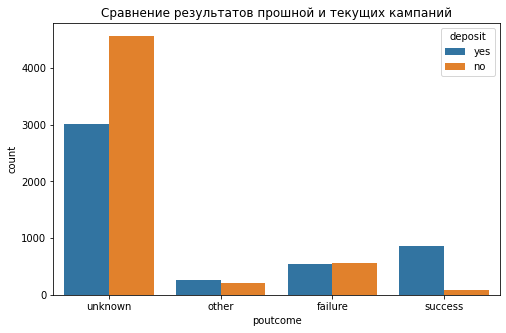

In [30]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
fig = plt.figure(figsize=(8,5))
sns.countplot(data=df_cleaned, x='poutcome', hue='deposit')
plt.title('Сравнение результатов прошной и текущих кампаний')

In [31]:
# Создаем сводную таблицу для вывода численных результатов
pivot_data = pd.pivot_table(
    data=df_cleaned,
    columns='deposit',
    index='poutcome',
    values='age',
    aggfunc= 'count'
)

display(pivot_data)

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


Вывод: 
Наилучшее соотношение удачных исходом нынешней кампании наблюдается для успешных результатов предыдущей кампании. Но в числовом выражении, 

In [32]:
# Вариант вывода числовых данных через группировку 
df_cleaned.groupby('poutcome')['deposit'].value_counts(ascending=True)

poutcome  deposit
failure   yes         547
          no          562
other     no          216
          yes         265
success   no           84
          yes         861
unknown   yes        3008
          no         4562
Name: deposit, dtype: int64

### Задание 7

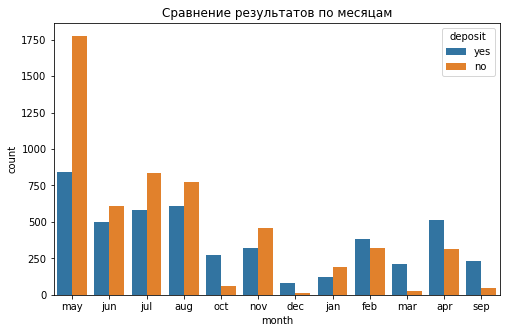

In [33]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
fig = plt.figure(figsize=(8,5))
sns.countplot(data=df_cleaned, x='month', hue='deposit')
plt.title('Сравнение результатов по месяцам')
plt.show()

In [34]:
# Расчитаем % отказов по месяцам

pivot_mounths = pd.pivot_table(
    data=df_cleaned,
    columns='deposit',
    index='month',
    values='age',
    aggfunc='count'
)
pivot_mounths['no_percent'] = pivot_mounths['no'] / (pivot_mounths['yes'] + pivot_mounths['no'])
pivot_mounths.sort_values(by=['no_percent'], ascending=False, inplace=True)
display(pivot_mounths)
print(f"Наибольшее число отказов было в месяце: {pivot_mounths.index[0]} и составило: {round(pivot_mounths['no_percent'][0]*100, 2)} %")

deposit,no,yes,no_percent
month,,,
may,1776,841,0.678640
jan,194,125,0.608150
jul,836,582,0.589563
nov,456,324,0.584615
aug,775,610,0.559567
jun,606,498,0.548913
feb,323,386,0.455571
apr,317,513,0.381928
oct,62,273,0.185075


Наибольшее число отказов было в месяце: may и составило: 67.86 %


In [35]:
# Поиск месяца с наибольшим числом отказов с помощью цикла
months = list(set(df_cleaned['month']))
# months
procent_max = 0

for month in months:
    procent = (df_cleaned[(df_cleaned['month'] == month) & (df_cleaned['deposit'] == 'no')]['month'].value_counts()/df_cleaned[(df_cleaned['month'] == month)]['month'].value_counts())[0]
      
    # print(month)
    # print(procent)
    
    if procent_max < procent:
        procent_max = procent
        worst_month = month
        
print(f"Наибольший процент отказов был в месяце: {worst_month} и составлял: {round(procent_max*100, 2)} %")
    


Наибольший процент отказов был в месяце: may и составлял: 67.86 %


### Задание 8

In [36]:
# создаем возрастные группы и определяем, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Сохздаем функцию для разделения по группам возрастов
def age_group(x):
    if x < 30:
        result = '<30'
    elif 30 <= x < 40:
        result = '30-40'
    elif 40 <= x < 50:
        result = '40-50'
    elif 50 <= x < 60:
        result = '50-60'
    else: result = '60+'
    
    return result
    
# Создаем новый столбец с группой возрастов
df_cleaned['age_group'] = df_cleaned['age'].apply(age_group)
df_cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


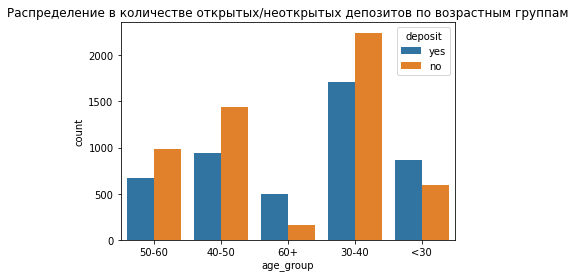

In [37]:
# Визуализируем результаты столбца deposit по различныи группам возрастов
sns.countplot(data=df_cleaned, x='age_group', hue='deposit')
plt.title('Распределение в количестве открытых/неоткрытых депозитов по возрастным группам')
plt.show()

In [38]:
# Реализуем разделение на группы с помощью метода cut()
# df_cleaned['age_group_2'] = pd.cut(df_cleaned['age'],
#                                    bins=[0, 30, 40, 50, 60, 100],
#                                    labels=['<30', '30-40', '40-50', '50-60', '60+'])

# df_cleaned.head()

In [39]:
age_pivot = pd.pivot_table(
    data=df_cleaned,
    index='age_group',
    columns='deposit',
    aggfunc='count',
    values='age'
)

age_pivot


deposit,no,yes
age_group,,
30-40,2245,1716
40-50,1444,938
50-60,984,670
60+,157,496
<30,594,861


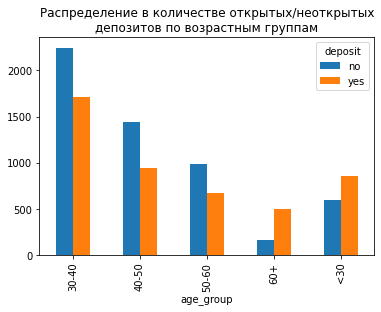

In [40]:
age_pivot.plot(kind='bar', title='Распределение в количестве открытых/неоткрытых\nдепозитов по возрастным группам');

### Задания 9 и 10

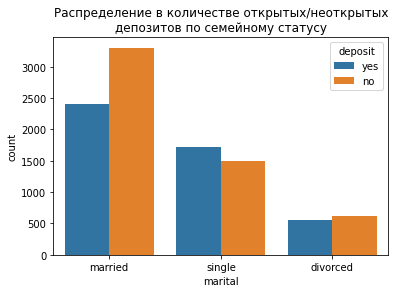

In [41]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(data=df_cleaned, x='marital', hue='deposit')
plt.title('Распределение в количестве открытых/неоткрытых\nдепозитов по семейному статусу');

In [42]:
# Посмотрим на распределение по статусам
marital_pivot = pd.pivot_table(
    df_cleaned,
    index='marital',
    columns='deposit',
    values='age',
    aggfunc='count'
)

marital_pivot['total'] = marital_pivot['no'] + marital_pivot['yes']
marital_pivot['total percentage'] = round(marital_pivot['total'] / marital_pivot['total'].sum() * 100, 2)
marital_pivot['success percentage'] = round(marital_pivot['yes'] / marital_pivot['total'] * 100, 2)
marital_pivot

deposit,no,yes,total,total percentage,success percentage
marital,,,,,
divorced,624,553,1177,11.65,46.98
married,3303,2412,5715,56.56,42.20
single,1497,1716,3213,31.80,53.41


**Вывод:**
1. Самое большое количество клиентов (около 57%) составляют женатые/замужние клиенты
2. Наибольший процент успеха кампании (около 53%) приходится на одиноких клиентов

In [43]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от образования
px.histogram(
    data_frame=df_cleaned,
    x='education',
    color='deposit',
    title='Распределение результатов кампании в зависимости от уровня образования',
    barmode='group'
)


In [44]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
px.histogram(
    data_frame=df_cleaned,
    x='job',
    color='deposit',
    title='Распределение результатов кампании в зависимости от сферы занятости',
    barmode='group'
)

In [45]:
# Посмотрим на распределение по сфере занятости
job_pivot = pd.pivot_table(
    df_cleaned,
    index='job',
    columns='deposit',
    values='age',
    aggfunc='count'
)

job_pivot['total'] = job_pivot['no'] + job_pivot['yes']
job_pivot['total percentage'] = round(job_pivot['total'] / job_pivot['total'].sum() * 100, 2)
job_pivot['success percentage'] = round(job_pivot['yes'] / job_pivot['total'] * 100, 2)
display(job_pivot.sort_values(by='success percentage', ascending=False))

print(f"Наибольшее число клиентов банка ({job_pivot.sort_values(by='total percentage', ascending=False)['total percentage'][0]} %) занято в {job_pivot.sort_values(by='total percentage', ascending=False).index[0]}")

deposit,no,yes,total,total percentage,success percentage
job,,,,,
student,81,245,326,3.23,75.15
retired,231,432,663,6.56,65.16
unemployed,143,189,332,3.29,56.93
management,1180,1135,2315,22.91,49.03
admin.,672,574,1246,12.33,46.07
technician,900,738,1638,16.21,45.05
self-employed,197,161,358,3.54,44.97
services,523,345,868,8.59,39.75
housemaid,153,99,252,2.49,39.29


Наибольшее число клиентов банка (22.91 %) занято в management


### Задание 11

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,832
single,100,866,531


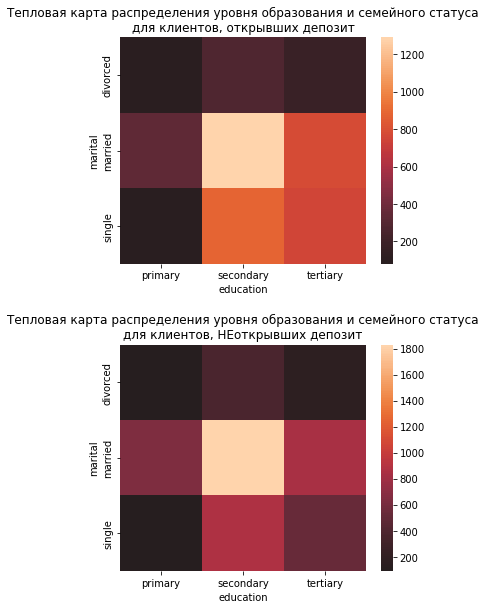

In [46]:
# Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл/ не открыл депозит)
pivot_data_success = pd.pivot_table(
    data=df_cleaned[df_cleaned['deposit'] == 'yes'],
    index='marital',
    columns='education',
    aggfunc='count',
    values='age'
)

display(pivot_data_success)

pivot_data_failure = pd.pivot_table(
    data=df_cleaned[df_cleaned['deposit'] == 'no'],
    index='marital',
    columns='education',
    aggfunc='count',
    values='age'
)

display(pivot_data_failure)

fig, axes = plt.subplots(2, 1, figsize=(5, 8))
fig.tight_layout(h_pad = 6) # настраиваем промежутки между графиками
sns.heatmap(
    pivot_data_success,
    # title='Тепловая карта зависимости семейного статуса и образования<br>для открывших депозит клиентов',
    ax=axes[0],
    center=0,
    
)

sns.heatmap(
    pivot_data_failure,
    ax=axes[1],
    center=0
)
axes[0].set_title('Тепловая карта распределения уровня образования и семейного статуса\nдля клиентов, открывших депозит')
axes[1].set_title('Тепловая карта распределения уровня образования и семейного статуса\nдля клиентов, НЕоткрывших депозит')
plt.show()

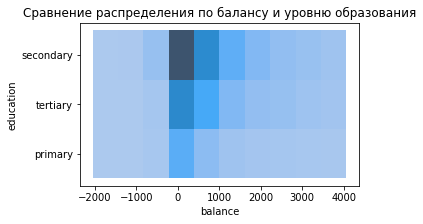

In [47]:
# Сравним распределение баланса по уровню образования
# px.histogram(
#     data_frame=df_cleaned,
#     x='balance',
#     color='education',
#     nbins=50,
#     title=('Сравнение распределения по балансу и уровню образования')
# )

fig = plt.figure(figsize=(5, 3))
sns.histplot(
    data=df_cleaned,
    x='balance',
    y='education',
    bins=10
)
plt.title('Сравнение распределения по балансу и уровню образования')
plt.show()
    


In [48]:
# сравнение по образованию и типу занятости
px.histogram(
    data_frame=df_cleaned,
    x='job',
    color='education',
    title='Распределение клиентов по сфере занятости и образованию',
    barmode='group'
)

**Вывод:**
Самым многочисленным является пересечение категорий married и secondary

## Часть 3: преобразование данных

### Задание 1

In [49]:
# преобразуем уровни образования
df_cleaned['education'] = LabelEncoder().fit_transform(df_cleaned['education'])
df_cleaned['education'].sum()

11995

In [50]:
# преобразуем группы возрастов 
df_cleaned['age_group'] = LabelEncoder().fit_transform(df_cleaned['age_group'])
df_cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


### Задания 2 и 3

In [51]:
# преобразуем бинарные переменные в представление из нулей и единиц
# целевая переменная deposit
df_cleaned['deposit'] = df_cleaned['deposit'].apply(lambda x: 0 if x == 'no' else 1)

print(f"Стандартное отклонение по признаку deposit = {np.std(df_cleaned['deposit']).round(3)}")
# df_cleaned['deposit'].std()

Стандартное отклонение по признаку deposit = 0.499


In [52]:
# Закодируем бинарные признаки с помощью LabelBinarizer
# переменная default
df_cleaned['default'] = LabelBinarizer().fit_transform(df_cleaned['default'])

# переменная housing
df_cleaned['housing'] = LabelBinarizer().fit_transform(df_cleaned['housing'])

# переменная loan
df_cleaned['loan'] = LabelBinarizer().fit_transform(df_cleaned['loan'])

df_cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [53]:
# Проверка результатов кодирования
print(f"Сумма средних значений по трем признакам: "
      f"{round((df_cleaned['default'].mean() + df_cleaned['loan'].mean() + df_cleaned['housing'].mean()), 3)}")

Сумма средних значений по трем признакам: 0.635


### Задание 4

In [54]:
# создайте дамми-переменные
df_cleaned = pd.get_dummies(data=df_cleaned)
df_cleaned.shape[1] - 1 + 5

50

### Задания 5 и 6

<Axes: >

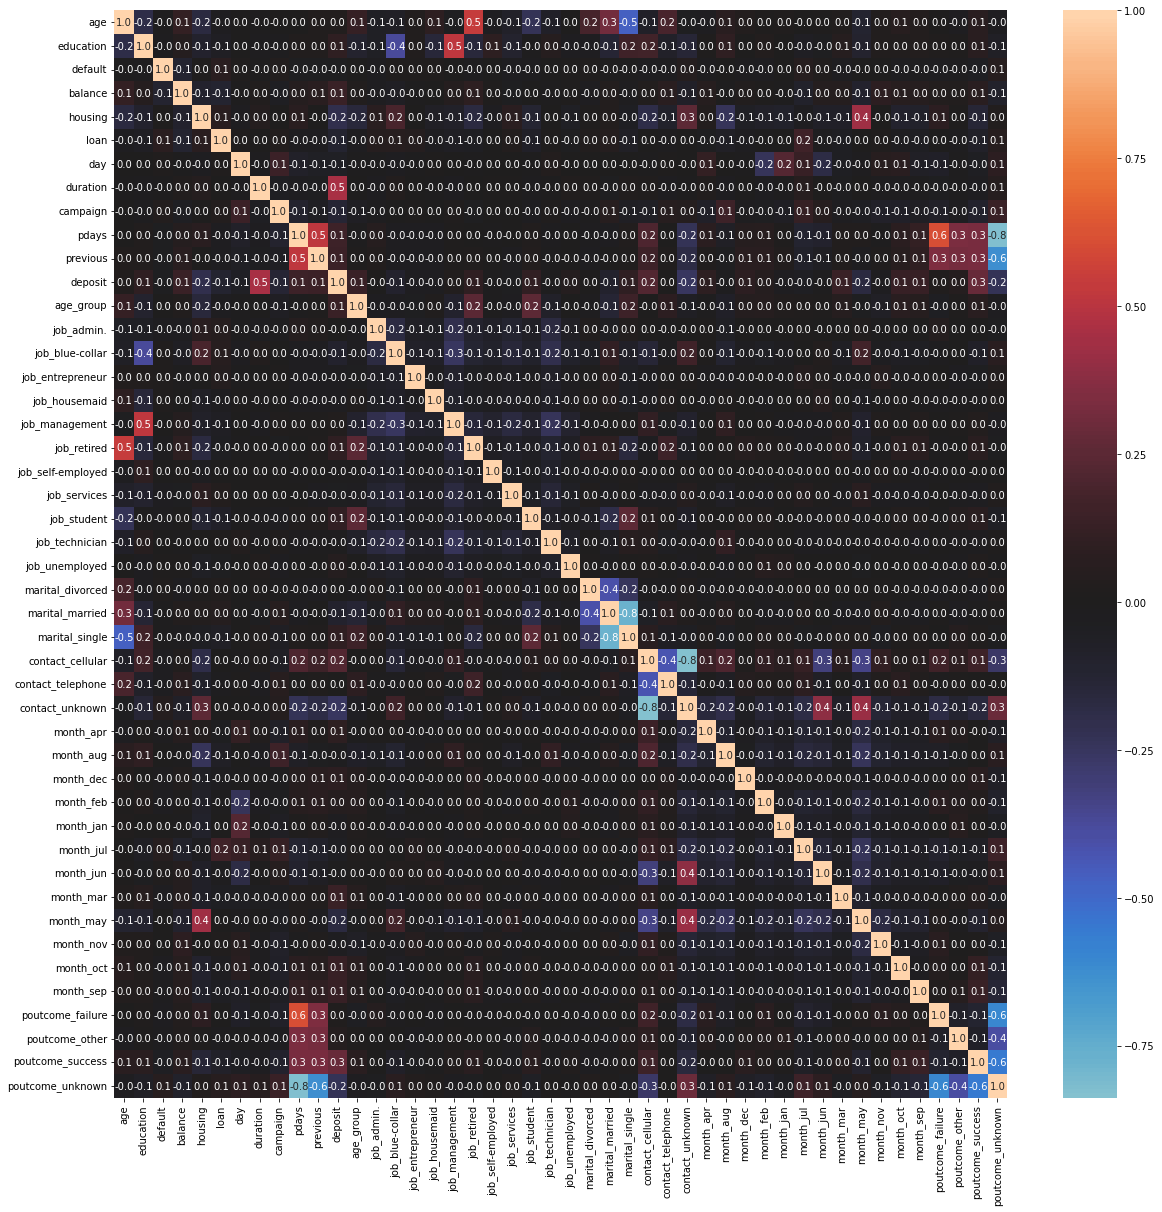

In [55]:
# построим корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(20,20))
sns.heatmap(df_cleaned.corr(), fmt='.1f', annot=True, center=0)

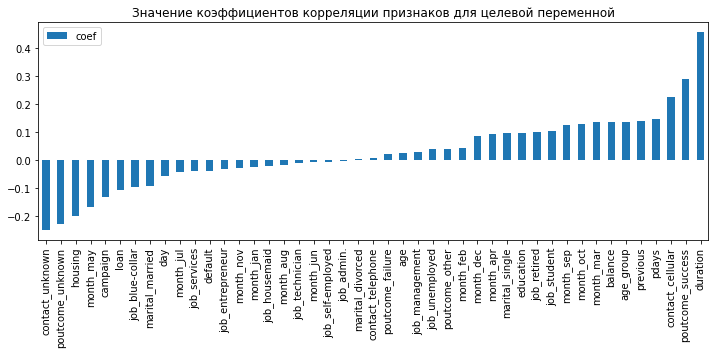

In [56]:
# Построи столбчатую диаграмму для ранжированных коэффициентов корреляции по отношению к целевому признаку
coef_data = pd.DataFrame(df_cleaned.corr()['deposit']).rename(columns={'deposit': 'coef'})
coef_data['feature'] = coef_data.index

coef_data[coef_data['feature'] != 'deposit'].sort_values(by='coef').plot(kind='bar', 
                                                                         figsize=(12, 4),
                                                                         title="Значение коэффициентов корреляции признаков для целевой переменной");


### Задания 7 и 8

In [57]:
X = df_cleaned.drop(['deposit'], axis=1)
y = df_cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [58]:
# рассчитаем размер тестовой выборки
print(f'Размер тестовой выборки: {X_test.shape}')

# рассчитаем среднее значение целевой переменной на тестовой выборке
print(f'Среднее значение целевой переменной на тестовой выборке: {y_test.mean().round(2)}')

Размер тестовой выборки: (3335, 45)
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [59]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков
Kbest = SelectKBest(score_func=f_classif, k=15)
Kbest.fit(X_train, y_train)
feature_names = list(Kbest.get_feature_names_out())
feature_names

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [60]:
# нормализуем данные с помощью minmaxsxaler
scaler = MinMaxScaler()
scaler.fit(X_train[feature_names])
X_train_scaled = pd.DataFrame(scaler.transform(X_train[feature_names]), columns=feature_names)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[feature_names]), columns=feature_names)

In [61]:
X_train_scaled.describe()

,balance,housing,duration,campaign,pdays,previous,age_group,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
count,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000
mean,0.466965,0.479321,0.095162,0.036108,0.060726,0.013862,0.331684,0.721713,0.216100,0.023338,0.262629,0.033973,0.026588,0.091581,0.751699
std,0.162911,0.499609,0.090391,0.064769,0.127478,0.038283,0.354170,0.448188,0.411614,0.150987,0.440095,0.181174,0.160888,0.288454,0.432059
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.350295,0.000000,0.035061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.407559,0.000000,0.065223,0.023810,0.000000,0.000000,0.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.535995,1.000000,0.124968,0.047619,0.000000,0.000000,0.500000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
# Рассчитаем среднее арифметическое для первого предиктора 
# (т. е. для первого столбца матрицы) из тестовой выборки
X_test_scaled.iloc[:, 0].mean().round(2)


0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [63]:
# обучим логистическую регрессию и рассчитаем метрики качества
lr_model = linear_model.LogisticRegression(
    random_state=42,
    solver='sag',
    max_iter=1000
)

lr_model.fit(X_train_scaled, y_train)

print(f"Accuracy для тестовой выборки: {metrics.accuracy_score(y_test, lr_model.predict(X_test_scaled)).round(2)}")

# ответ на платформе 0,81 из-за разницы версий библиотек

Метрика accuracy: 0.8


### Задания 2,3,4

In [64]:
# обучим решающие деревья, настроим максимальную глубину
dt_model = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt_model.fit(X_train_scaled, y_train)

print(f'Accuracy для тестовой выборки: {metrics.accuracy_score(y_test, dt_model.predict(X_test_scaled)).round(2)}')
print(f'Accuracy для тренировочной выборки: {metrics.accuracy_score(y_train, dt_model.predict(X_train_scaled))}')

Accuracy для тестовой выборки: 0.75
Accuracy для тренировочной выборки: 1.0


**Вывод:** по результатам метрики полученным для тестовой и тренировойной выборки можно сделать вывод о переобучении модели.

In [65]:
# Подберем максимальную глубину дерева, при которой нет переобучения
accuracy_train = list()
accuracy_test = list()
# Создаем список вариантов глубины дерева
max_depth_list = np.arange(2, 30, 1)

# В цикле проверим результаты для различных порогов
for depth in max_depth_list:
    dt_model_2 = tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42,
        max_depth=depth
    )
    dt_model_2.fit(X_train_scaled, y_train)
    accuracy_test.append(metrics.accuracy_score(y_test, dt_model_2.predict(X_test_scaled)))
    accuracy_train.append(metrics.accuracy_score(y_train, dt_model_2.predict(X_train_scaled)))

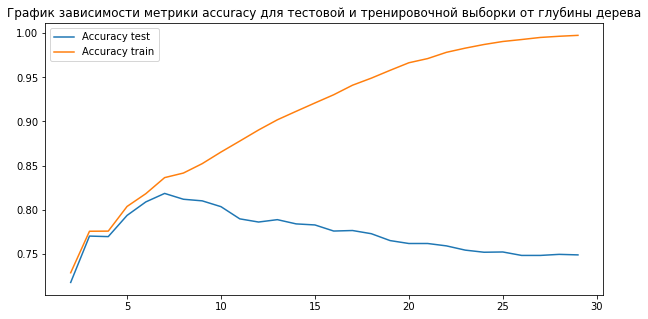

In [66]:
# Визуализируем метрики 
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(max_depth_list, accuracy_test, label='Accuracy test')
ax.plot(max_depth_list, accuracy_train, label='Accuracy train')
ax.set_title('График зависимости метрики accuracy для тестовой и тренировочной выборки от глубины дерева')
ax.legend();

In [67]:
# Создаем датафрейм с результатами
dt_accuracy_df = pd.DataFrame({'acc_train': accuracy_train, 'acc_test': accuracy_test})
dt_accuracy_df.set_index(max_depth_list, inplace=True)
dt_accuracy_df.index.rename('max depth', inplace=True)
# Визуализируем с помощью plotly.express
fig = px.line(dt_accuracy_df[['acc_test', 'acc_train']],
        title='График зависимости метрики accuracy для тестовой и тренировочной выборки от глубины дерева',
        )
fig.update_layout(yaxis_title='accuracy') # переименовываем ось у
fig.show()

In [68]:
print(f"Наибольшее значение accuracy для тестовой выборки получается {dt_accuracy_df['acc_test'].max().round(2)} для глубины дерева {dt_accuracy_df['acc_test'].idxmax()}")

# ответы на платформе 0.81 и 6

Наибольшее значение accuracy для тестовой выборки получается 0.82 для глубины дерева 7


In [119]:
# Создаем модель дерева решений с оптимальной глубиной
dt_model_best_depth = tree.DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    max_depth=dt_accuracy_df['acc_test'].idxmax()
)

# Обучаем модель
dt_model_best_depth.fit(X_train_scaled, y_train)

# Выводим метрики
print('F1-score для тестовой выборки: {:.3f}'.format(metrics.f1_score(y_test, dt_model_best_depth.predict(X_test_scaled))))
print('Accuracy для тестовой выборки: {:.3f}'.format(metrics.accuracy_score(y_test, dt_model_best_depth.predict(X_test_scaled))))

F1-score для тестовой выборки: 0.802
Accuracy для тестовой выборки: 0.814


### Задание 5

In [69]:
# подберем оптимальные параметры с помощью gridsearch
# Задаем сетку для поиска
param_grid = {'min_samples_split': [2, 5, 7, 10], # минимальное количество объектов для разбиения узла
              'max_depth': [3, 5, 7] # максимальная глубина дерева
              }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print('F1-score на тестовой выборке: {:.2f}'. format(metrics.f1_score(y_test, grid_search.predict(X_test_scaled))))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search.best_params_))

# ответ на платформе 0.79

F1-score на тестовой выборке: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [70]:
# обучим модель случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100, # количество деревьев
    criterion='gini', # метрика качества
    min_samples_leaf=5, # минимальное число объектов в листе
    max_depth=10, # максимальная глубина дерева
    random_state=42
    )

rf.fit(X_train_scaled, y_train)

# Выводим значения метрик
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, rf.predict(X_test_scaled))))
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, rf.predict(X_test_scaled))))
print('F1-score: {:.2f}'.format(metrics.f1_score(y_test, rf.predict(X_test_scaled))))
# на платформе recall 0.84

Accuracy: 0.83
Recall: 0.83
F1-score: 0.82


### Задания 2 и 3

In [71]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом

# Создаем объект класса градиентный бустинг
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, # темп обучения
    n_estimators=300, # количество деревьев
    min_samples_leaf=5, # минимальное число объектов в листе
    max_depth=5, # максимальная глубина дерева
    random_state=42
    )

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Выводим значения метрик
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, gb.predict(X_test_scaled))))
print('Recall: {:.3f}'.format(metrics.recall_score(y_test, gb.predict(X_test_scaled))))
print('F1-score: {:.3f}'.format(metrics.f1_score(y_test, gb.predict(X_test_scaled))))

Accuracy: 0.827
Recall: 0.832
F1-score: 0.817


**Вывод:** метрики для случайного леса и градиентного бустинка практически одинаковые, однако на выполнение алгоритма случайного леса затрачено меньше времени

### Задание 4

In [72]:
# объединим использованные алгоритмы с помощью стекинга 
# Создаем список кортежей с моделями
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42
        )),
    ('lr', linear_model.LogisticRegression(
        random_state=42,
        solver='sag',
        max_iter=1000
        )),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        ))
]

# Создаем объект класса стекинг
stacking_model = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        random_state=42,
        solver='sag',
        max_iter=1000
        )
)

# Обучаем модель
stacking_model.fit(X_train_scaled, y_train)

# Оцениваем метрику
print('Precision: {:.3f}'.format(metrics.precision_score(y_test, stacking_model.predict(X_test_scaled))))

# ответ на платформе 0.82

Precision: 0.807


### Задание 5

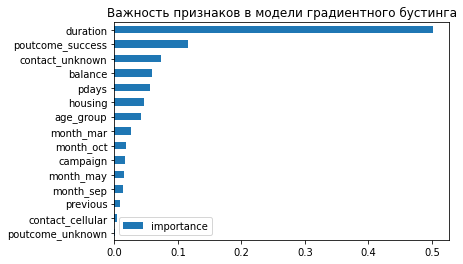

In [73]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gb_feature_imp = pd.DataFrame(gb.feature_importances_, columns=['importance'])
gb_feature_imp.set_index(X_test_scaled.columns, inplace=True)
gb_feature_imp.sort_values(by='importance').plot(kind='barh', title='Важность признаков в модели градиентного бустинга');



### Задания 6,7,8

In [74]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
# Создем функцию для оптимизации для случайного леса
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
    
    return score

In [75]:
# Создаем объект исследования
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# Ищем лучшую комбинацию гиперпараметров
study.optimize(optuna_rf, n_trials=50)

[I 2023-12-12 09:25:03,832] A new study created in memory with name: RandomForestClassifier
[I 2023-12-12 09:25:05,576] Trial 0 finished with value: 0.8983503534956795 and parameters: {'n_estimators': 144, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8983503534956795.
[I 2023-12-12 09:25:07,144] Trial 1 finished with value: 0.861480669901393 and parameters: {'n_estimators': 171, 'max_depth': 21, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8983503534956795.
[I 2023-12-12 09:25:08,661] Trial 2 finished with value: 0.8616155291170945 and parameters: {'n_estimators': 169, 'max_depth': 21, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8983503534956795.
[I 2023-12-12 09:25:09,884] Trial 3 finished with value: 0.8456101774776189 and parameters: {'n_estimators': 154, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8983503534956795.
[I 2023-12-12 09:25:10,750] Trial 4 finished with value: 0.8501960784313726 and parameters: {'n_

In [76]:
# прододжим подбор
study.optimize(optuna_rf, n_trials=30)

[I 2023-12-12 09:26:28,868] Trial 50 finished with value: 0.9252936570086139 and parameters: {'n_estimators': 170, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 48 with value: 0.9253170502583372.
[I 2023-12-12 09:26:31,035] Trial 51 finished with value: 0.9253170502583372 and parameters: {'n_estimators': 172, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 48 with value: 0.9253170502583372.
[I 2023-12-12 09:26:33,152] Trial 52 finished with value: 0.9243776420854861 and parameters: {'n_estimators': 171, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 48 with value: 0.9253170502583372.
[I 2023-12-12 09:26:35,410] Trial 53 finished with value: 0.9226432821797683 and parameters: {'n_estimators': 182, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 48 with value: 0.9253170502583372.
[I 2023-12-12 09:26:36,822] Trial 54 finished with value: 0.8585289514866979 and parameters: {'n_estimators': 169, 'max_depth': 26, 'min_samples_leaf': 7}. Best is trial 48 with va

In [77]:
# Выводим результаты по обучающей выборке
print('Наилучшие значения гиперпараметров: {}'.format(study.best_params))
print('F1-score на обучающей выборке: {:.2f}'.format(study.best_value))

Наилучшие значения гиперпараметров: {'n_estimators': 179, 'max_depth': 27, 'min_samples_leaf': 2}
F1-score на обучающей выборке: 0.93


In [78]:
# Рассчитаем результат для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)

print('F1-score для тестовой выборки: {:.3f}'.format(metrics.f1_score(y_test, model.predict(X_test_scaled))))
print('Accuracy для тестовой выборки: {:.3f}'.format(metrics.accuracy_score(y_test, model.predict(X_test_scaled))))

# ответы на платформе 0.83 и 0.84 соответствиенно

F1-score для тестовой выборки: 0.816
Accuracy для тестовой выборки: 0.824


In [125]:
# Создаем таблицу с результатами
results = pd.DataFrame(columns=['Method', 'F1-score', 'Accuracy', 'Recall', 'Precision'])

results = results.append(pd.DataFrame({'Method': ['LogisticRegression'], 'F1-score': [metrics.f1_score(y_test, lr_model.predict(X_test_scaled)).round(3)], 'Accuracy': [metrics.accuracy_score(y_test, lr_model.predict(X_test_scaled)).round(3)], 'Recall': [metrics.recall_score(y_test, lr_model.predict(X_test_scaled)).round(3)], 'Precision': [metrics.precision_score(y_test, lr_model.predict(X_test_scaled)).round(3)]}), ignore_index=True)
results = results.append(pd.DataFrame({'Method': ['DecisionTree'], 'F1-score': [metrics.f1_score(y_test, dt_model.predict(X_test_scaled)).round(3)], 'Accuracy': [metrics.accuracy_score(y_test, dt_model.predict(X_test_scaled)).round(3)], 'Recall': [metrics.recall_score(y_test, dt_model.predict(X_test_scaled)).round(3)], 'Precision': [metrics.precision_score(y_test, dt_model.predict(X_test_scaled)).round(3)]}), ignore_index=True)
results = results.append(pd.DataFrame({'Method': ['DecisionTree (best depth)'], 'F1-score': [metrics.f1_score(y_test, dt_model_best_depth.predict(X_test_scaled)).round(3)], 'Accuracy': [metrics.accuracy_score(y_test, dt_model_best_depth.predict(X_test_scaled)).round(3)], 'Recall': [metrics.recall_score(y_test, dt_model_best_depth.predict(X_test_scaled)).round(3)], 'Precision': [metrics.precision_score(y_test, dt_model_best_depth.predict(X_test_scaled)).round(3)]}), ignore_index=True)
results = results.append(pd.DataFrame({'Method': ['GridSearch'], 'F1-score': [metrics.f1_score(y_test, grid_search.predict(X_test_scaled)).round(3)], 'Accuracy': [metrics.accuracy_score(y_test, grid_search.predict(X_test_scaled)).round(3)], 'Recall': [metrics.recall_score(y_test, grid_search.predict(X_test_scaled)).round(3)], 'Precision': [metrics.precision_score(y_test, grid_search.predict(X_test_scaled)).round(3)]}), ignore_index=True)
results = results.append(pd.DataFrame({'Method': ['RandomForest'], 'F1-score': [metrics.f1_score(y_test, rf.predict(X_test_scaled)).round(3)], 'Accuracy': [metrics.accuracy_score(y_test, rf.predict(X_test_scaled)).round(3)], 'Recall': [metrics.recall_score(y_test, rf.predict(X_test_scaled)).round(3)], 'Precision': [metrics.precision_score(y_test, rf.predict(X_test_scaled)).round(3)]}), ignore_index=True)
results = results.append(pd.DataFrame({'Method': ['GradientBoosting'], 'F1-score': [metrics.f1_score(y_test, gb.predict(X_test_scaled)).round(3)], 'Accuracy': [metrics.accuracy_score(y_test, gb.predict(X_test_scaled)).round(3)], 'Recall': [metrics.recall_score(y_test, gb.predict(X_test_scaled)).round(3)], 'Precision': [metrics.precision_score(y_test, gb.predict(X_test_scaled)).round(3)]}), ignore_index=True)
results = results.append(pd.DataFrame({'Method': ['Stacking'], 'F1-score': [metrics.f1_score(y_test, stacking_model.predict(X_test_scaled)).round(3)], 'Accuracy': [metrics.accuracy_score(y_test, stacking_model.predict(X_test_scaled)).round(3)], 'Recall': [metrics.recall_score(y_test, stacking_model.predict(X_test_scaled)).round(3)], 'Precision': [metrics.precision_score(y_test, stacking_model.predict(X_test_scaled)).round(3)]}), ignore_index=True)
results = results.append(pd.DataFrame({'Method': ['RandomForest+Optuna'], 'F1-score': [metrics.f1_score(y_test, model.predict(X_test_scaled)).round(3)], 'Accuracy': [metrics.accuracy_score(y_test, model.predict(X_test_scaled)).round(3)], 'Recall': [metrics.recall_score(y_test, model.predict(X_test_scaled)).round(3)], 'Precision': [metrics.precision_score(y_test, model.predict(X_test_scaled)).round(3)]}), ignore_index=True)

results

,Method,F1-score,Accuracy,Recall,Precision
0,LogisticRegression,0.777,0.805,0.734,0.825
1,DecisionTree,0.722,0.747,0.709,0.736
2,DecisionTree (best depth),0.802,0.814,0.812,0.792
3,GridSearch,0.802,0.814,0.812,0.792
4,RandomForest,0.819,0.828,0.835,0.803
5,GradientBoosting,0.817,0.827,0.832,0.802
6,Stacking,0.807,0.821,0.806,0.807
7,RandomForest+Optuna,0.816,0.824,0.84,0.792


**Вывод:** применение оптимизации гиперпараметров Optuna позволило улучшить метрики по ставнению с GridSearch и стекингом. Однако метрики для случайного леса и градиентного бустинга получаются сравнимыми. 

С учетом затраченного времени на оптимизацию гиперпараметров, наилучшие метрики получены для первоначальной модели RandomForest. 